In [1]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time
from functools import reduce
import catboost
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('mode.chained_assignment',  None)
pd.set_option('display.max_columns',500)

merge_df = pd.read_csv('merge_df.csv')
merge_df.shape

(289, 252)

In [2]:
merge_df = merge_df.fillna(merge_df.mean())

In [3]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import catboost
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)
sc = StandardScaler()

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]
    
    x_train = pd.DataFrame(sc.fit_transform(x_train), columns=x_train.columns)
    x_test = pd.DataFrame(sc.transform(x_test), columns=x_test.columns)
    
    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)
    
    # SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )

    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    
    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.14451715310407284
roc_auc_score :  0.60625
acc :  0.5172413793103449
sensitivity :  0.9
specificity :  0.4375
pr_auc :  0.21539341707112736 

[[21 27]
 [ 1  9]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.24014157774513467
roc_auc_score :  0.83125
acc :  0.8275862068965517
sensitivity :  0.8
specificity :  0.8333333333333334
pr_auc :  0.3884193355663944 

[[40  8]
 [ 2  8]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.3439849934619274
roc_auc_score :  0.6125
acc :  0.6379310344827587
sensitivity :  0.7
specificity :  0.625
pr_auc :  0.30009776569551255 

[[30 18]
 [ 3  7]]
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
Youden index threshold :  0.4746802066866401
roc_auc_score :  0.6258503401360543
acc :  0.8620689655172413
sensitivity :  0.3333333333333333
specificity :  0.9591836734693877
pr_auc :  0.26

In [4]:
np.mean(proba_score) #smote 54

0.6787903911564627

In [ ]:
proba_score

[0.60625,
 0.83125,
 0.6125,
 0.6258503401360543,
 0.6597222222222222,
 0.6416666666666666,
 0.7520833333333334,
 0.75,
 0.7188208616780044,
 0.6898148148148149,
 0.7291666666666666,
 0.5541666666666667,
 0.56875,
 0.5396825396825397,
 0.787037037037037,
 0.6375,
 0.6833333333333333,
 0.6479166666666667,
 0.7324263038548753,
 0.8078703703703703]

In [ ]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

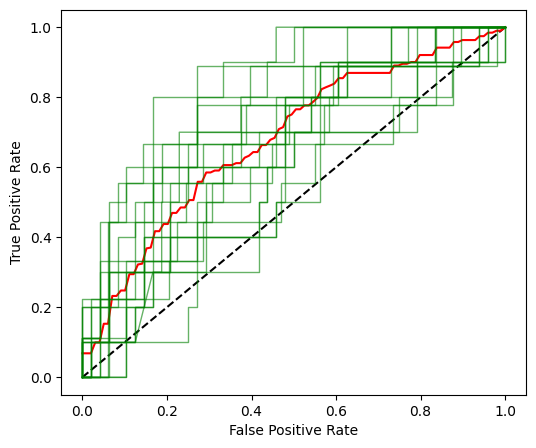

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

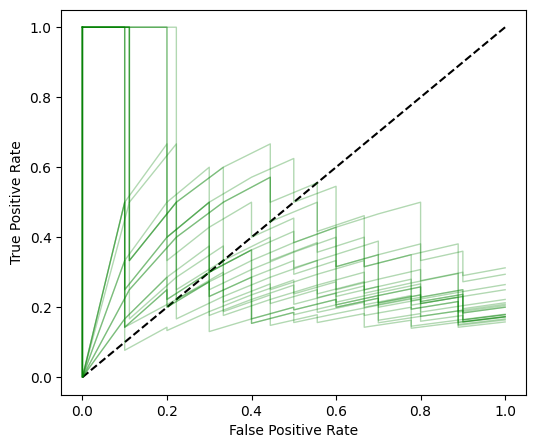

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

# 1010

In [ ]:
merge_df = pd.read_csv('merge_df.csv')
merge_df = merge_df.fillna(merge_df.mean())
merge_df.shape

(289, 252)

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
import catboost
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=10,random_state=seed,n_repeats=10)
sc = StandardScaler()

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    for col in x_train.columns:
         x_test.loc[:, col] = x_test[col].fillna(x_train[col].mean())
    
    x_train = pd.DataFrame(sc.fit_transform(x_train), columns=x_train.columns)
    x_test = pd.DataFrame(sc.transform(x_test), columns=x_test.columns)
    
    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)
    
    # SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )

    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    
    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
Youden index threshold :  0.04985935327060359
roc_auc_score :  0.7666666666666666
acc :  0.6551724137931034
sensitivity :  1.0
specificity :  0.5833333333333334
pr_auc :  0.4328571428571429 

[[14 10]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
Youden index threshold :  0.2961562822933077
roc_auc_score :  0.7666666666666667
acc :  0.6206896551724138
sensitivity :  1.0
specificity :  0.5416666666666666
pr_auc :  0.5609586247086247 

[[13 11]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
Youden index threshold :  0.4965403240823048
roc_auc_score :  0.9416666666666667
acc :  0.9310344827586207
sensitivity :  1.0
specificity :  0.9166666666666666
pr_auc :  0.5730952380952381 

[[22  2]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
Youden index threshold :  0.3670825564203319
roc_auc_score :  0.8500000000000001
acc :  0.7241379310344828
sensitivity :  1.0
specifi

In [ ]:
np.mean(proba_score) 

0.6762999999999999

In [ ]:
proba_score

[0.7666666666666666,
 0.7666666666666667,
 0.9416666666666667,
 0.8500000000000001,
 0.8666666666666667,
 0.6,
 0.85,
 0.4916666666666667,
 0.8500000000000001,
 0.5625,
 0.4666666666666667,
 0.7,
 0.725,
 0.7416666666666667,
 0.7333333333333334,
 0.6583333333333333,
 0.7083333333333334,
 0.6666666666666667,
 0.7900000000000001,
 0.8645833333333333,
 0.5166666666666667,
 0.7166666666666667,
 0.6916666666666667,
 0.6583333333333333,
 0.475,
 0.7166666666666668,
 0.6666666666666666,
 0.6083333333333334,
 0.6599999999999999,
 0.6770833333333333,
 0.8166666666666667,
 0.6833333333333333,
 0.5,
 0.8583333333333333,
 0.8999999999999999,
 0.6166666666666667,
 0.5916666666666666,
 0.6083333333333334,
 0.85,
 0.6666666666666666,
 0.45833333333333337,
 0.6166666666666667,
 0.8,
 0.6916666666666667,
 0.7999999999999999,
 0.8833333333333333,
 0.5833333333333334,
 0.6583333333333334,
 0.77,
 0.45833333333333337,
 0.6583333333333333,
 0.39999999999999997,
 0.7,
 0.575,
 0.5333333333333332,
 0.8333333

In [ ]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

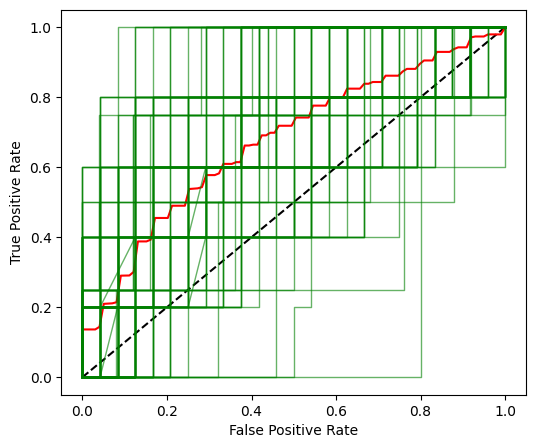

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

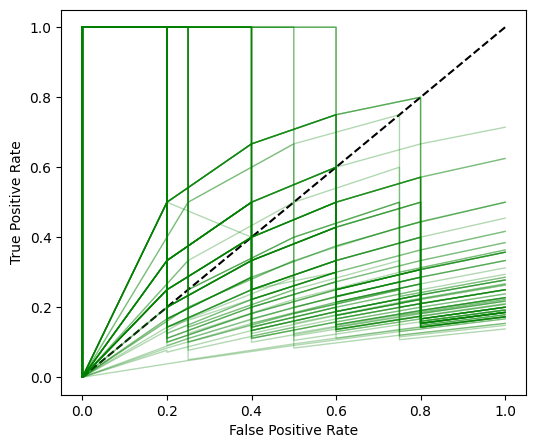

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

In [ ]:
CF_item = pd.DataFrame()
CF_item['proba_score'] = proba_score
CF_item['re_score'] = re_score
CF_item['specifi_score'] = specifi_score 
CF_item.to_csv('train_mean_1010.csv',index=False)